In [135]:
import numpy as np
import pandas as pd
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
import itertools

# sklearn preprocessing and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

# Hyper Parameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Boosting
import xgboost as xgb
import catboost as cb

# sklearn classification metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, recall_score, classification_report

# sklearn utils
from sklearn.utils.fixes import loguniform

# SMOTE
from imblearn.over_sampling import SMOTE

# Neural Nets
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.constraints import maxnorm
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy

In [26]:
def displayOptions(df):
    pd.options.display.max_rows = df.shape[0]
    pd.options.display.max_columns = df.shape[1]
    
def barplt(df, col, title, xlab, ylab):
    pd.value_counts(df[col]).plot.bar()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
def plotHistogram(df, col, y):
    ax = df.hist(column=col, by=y, bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

    for i,x in enumerate(ax):

        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Set x-axis label
        x.set_xlabel(col, labelpad=20, weight='bold', size=12)

        # Set y-axis label
        if i == 1:
            x.set_ylabel("Units", labelpad=50, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

        x.tick_params(axis='x', rotation=0)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def Prediction(model, X, y, which_dataset):
    y_pred     = model.predict(X)
    cnf_matrix = confusion_matrix(y, y_pred) 
    
    print(classification_report(y, y_pred, labels=[0, 1]))

    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
    plt.show()
    
    return y_pred

# def ROCcurve(model, X_train, y_train, X_test, y_test):
#     tmp = model.fit(X_train, y_train.ravel())

#     y_pred_sample_score = tmp.predict(X_test) #decision_function(X_test)
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

#     roc_auc = auc(fpr,tpr)

#     # Plot ROC
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
#     plt.legend(loc='lower right')
#     plt.plot([0,1],[0,1],'r--')
#     plt.xlim([-0.1,1.0])
#     plt.ylim([-0.1,1.01])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()

def ROCcurve(y_pred_sample_score, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
def objective_function(params, X_train, y_train):
    clf = xgb.XGBClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring = 'roc_auc_ovr_weighted', n_jobs = -1).mean()
    return {'loss': 1-score, 'status': STATUS_OK}  

In [3]:
df = pd.read_csv("../01. Data/ccdata.csv")
displayOptions(df)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1. Preprocessing

### 1.1 Check for class distribution

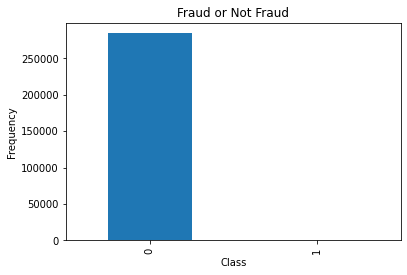

In [4]:
barplt(df, 'Class', 'Fraud or Not Fraud', 'Class', 'Frequency')

In [206]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


As we can see from the dataframe desacribe, we need to normalize the column Amount before proceeding with sampling. 

And time doesn't look like a useful parameter

In [126]:
X_train[v_features].shape

(227845, 29)

### 1.2 Let's create training and validation set

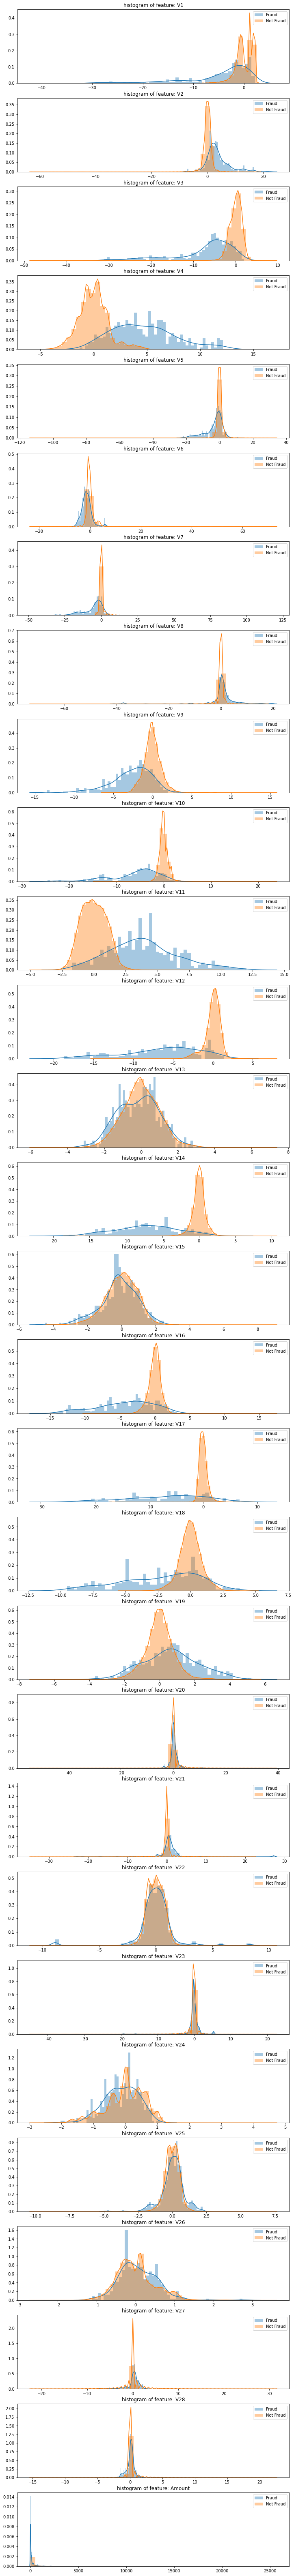

In [130]:
df1 = df.drop(['Time'], axis = 1) # We will not be using time in this analysis

## Extract features and response
X = df1.drop('Class', axis = 1)
y = df1['Class']

print('Shape of X : {}'.format(X.shape))
print('Shape of y : {}'.format(y.shape))

## Stratified split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 2612)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Let's check the distribution of each column

graph_y_train = ["Fraud"  if i == 1 else "Normal" for i in y_train]

#Distributions for each feature
v_features = X_train.columns

plt.figure(figsize=(12,29*4))
gs = gridspec.GridSpec(29, 1)
for i, cn in enumerate(X_train[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[cn][y_train == 1], bins=50, label = "Fraud")
    sns.distplot(X_train[cn][y_train == 0], bins=50, label = "Not Fraud")
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
    plt.legend()    
plt.show() 

### 1.3 Scaling and Standardizing and sampling with SMOTE

In [7]:
# Use the same scaler:  you should normalize the training set 
# and then use the same normalization steps on the test set

scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm  = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns) 

print("Before oversampling, count of label 1", sum(y_train == 1))
print("Before oversampling, count of label 0", sum(y_train == 0))

# Call the smote function
sm = SMOTE(random_state = 2612)
X_train_res, y_train_res = sm.fit_sample(X_train_norm, y_train.ravel()) ## ravel() is used to convert a nD array into a 1D array

print("\nAfter oversampling, count of label 1", sum(y_train_res == 1))
print("After oversampling, count of label 0", sum(y_train_res == 0))

Before oversampling, count of label 1 394
Before oversampling, count of label 0 227451

After oversampling, count of label 1 227451
After oversampling, count of label 0 227451


## 2. Modeling

### 2.0 PCA

In [14]:
X_train.shape

(227845, 29)

Even though we have 29 features to work with, we will not be using PCA here because these variables are already principal components. Due to proprietary reasons, the variables were masked and only the Principal components were provided

### 2.1 Logistic Regression Model with Grid Search

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    227451
           1       0.06      0.93      0.11       394

    accuracy                           0.97    227845
   macro avg       0.53      0.95      0.55    227845
weighted avg       1.00      0.97      0.99    227845



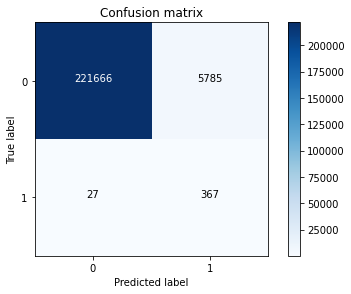


Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.88      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.97      0.99     56962



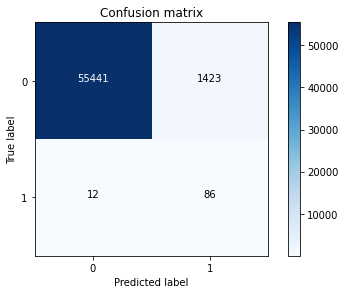

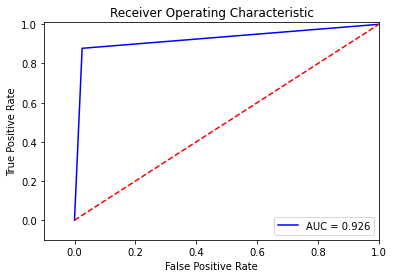

In [29]:
# 1. Logistic Regression Model with Grid Search
parameters = {
    'C':np.linspace(1,10,10)
}

# 2. define model
logReg = LogisticRegression()

# 3. Use grid search to find the best value of C
'''
The trade-off parameter of logistic regression that determines the strength of the regularization is called C
and higher values of C correspond to less regularization (where we can specify the regularization function).
C is actually the Inverse of regularization strength(lambda)
'''
clf = GridSearchCV(logReg, parameters, cv = 10, verbose = 5, n_jobs = 3)
clf.fit(X_train_res, y_train_res)

print(clf.best_params_)

# 4. Tune the model based on the best parameter and fit it on the resampled data
logReg1 = LogisticRegression(C = 1, penalty = 'l2', verbose = 5)
logReg1.fit(X_train_res, y_train_res)

# 5. Train Pred
print("Classificaiton Report: Train")
y_train_pred = Prediction(logReg1, X_train_norm, y_train, "train dataset")

# 6. Test Pred
print("\nClassificaiton Report: Test")
y_test_pred = Prediction(logReg1, X_test_norm, y_test, "test dataset")

# 7. ROC curve
# ROCcurve(logReg1, X_train_res, y_train_res, X_test_norm, y_test)
ROCcurve(y_test_pred, y_test)

### 2.2 Random Forest

In [72]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}


# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier(n_estimators = 50)

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores

# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=5, 
#                                scoring = 'roc_auc_ovr_weighted',
#                                random_state=2612, 
#                                n_jobs = -1)

# # Fit the random search model
# rf_random.fit(X_train_res, y_train_res)

# # best parameters from fitting the random search
# rf_random.best_params_

ROC_AUC: 1.000 (0.000)
Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



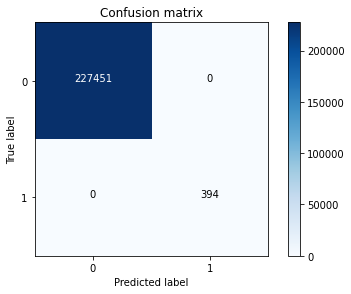

Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.82      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



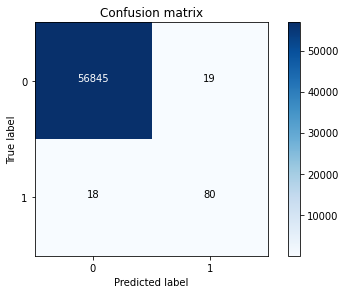

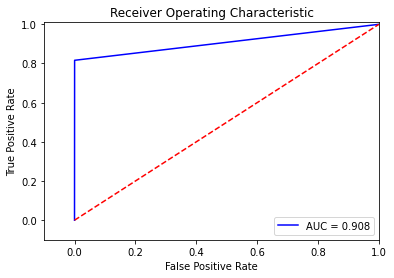

In [74]:
# 1. define model
rf = RandomForestClassifier(n_estimators = 20)

# 2. define model evaluation method
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 2612)

# 3. Score the model
scores = cross_val_score(rf, X_train_res, y_train_res, scoring = 'roc_auc_ovr_weighted', cv=cv, n_jobs = -1)

# 4. What's the performance?
print("ROC_AUC: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

# 5. Let's fit the model
rf.fit(X_train_res, y_train_res)

# 6. Train Pred
print("Classificaiton Report: Train")
y_train_pred_rf = Prediction(rf, X_train_norm, y_train, "train dataset")

# 7. Test Pred
print("Classificaiton Report: Test")
y_test_pred_rf = Prediction(rf, X_test_norm, y_test, "test dataset")

# 8. ROC
ROCcurve(y_test_pred_rf, y_test)

### 2.3 SVM

In [83]:
# # 1. Define the model
# svm = SVC(gamma = 'scale')

# # 2. Define Grid
# parameters = {'C': loguniform(1e0, 1e2),
#              'gamma': loguniform(1e-4, 1e-3),
#              'kernel': ['rbf'],
#              'class_weight':['balanced', None]
#              }

# # 3. Evaluation Procedure
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 2612)

# # 4. Grid Search
# grid = RandomizedSearchCV(svm, parameters, scoring='roc_auc', cv=cv, n_jobs=-1)
# grid_result = grid.fit(X_train_res, y_train_res)

# # 5. All configurations
# means = grid_result.cv_results_['mean_test_score']
# stds  = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
# # 6. Best Configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    227451
           1       0.11      0.99      0.20       394

    accuracy                           0.99    227845
   macro avg       0.56      0.99      0.60    227845
weighted avg       1.00      0.99      0.99    227845



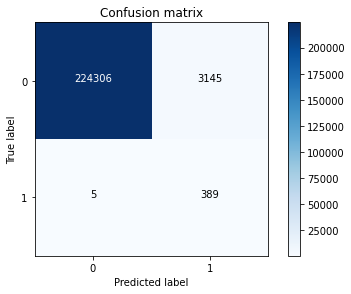


Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.82      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.90      0.58     56962
weighted avg       1.00      0.99      0.99     56962



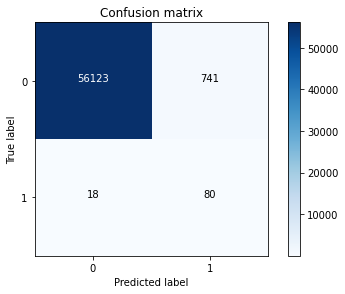

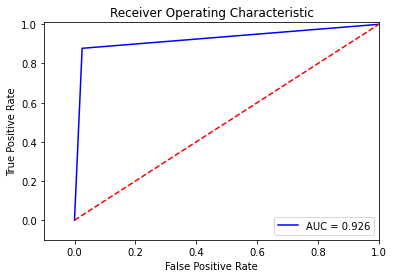

In [84]:
# 7. Tune the model based on the best parameter and fit it on the resampled data
#svmBest = SVC(gamma = , C = ,  )
svmBest = SVC(gamma = 'scale') ## Still to run SVM hyperparameter tuning
svmBest.fit(X_train_res, y_train_res)

# 5. Train Pred
print("Classificaiton Report: Train")
y_train_pred_svm = Prediction(svmBest, X_train_norm, y_train, "train dataset")

# 6. Test Pred
print("\nClassificaiton Report: Test")
y_test_pred_svm = Prediction(svmBest, X_test_norm, y_test, "test dataset")

# 7. ROC curve
# ROCcurve(logReg1, X_train_res, y_train_res, X_test_norm, y_test)
ROCcurve(y_test_pred, y_test)

### 2.4 LDA model

Mean ROC_AUC score: 0.981 (0.000)
Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.76      0.81       394

    accuracy                           1.00    227845
   macro avg       0.93      0.88      0.90    227845
weighted avg       1.00      1.00      1.00    227845



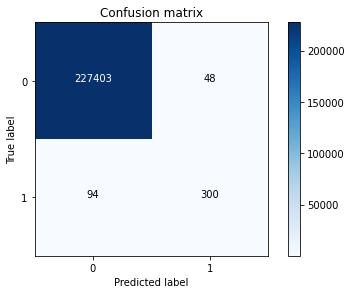

Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.74      0.80        98

    accuracy                           1.00     56962
   macro avg       0.93      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



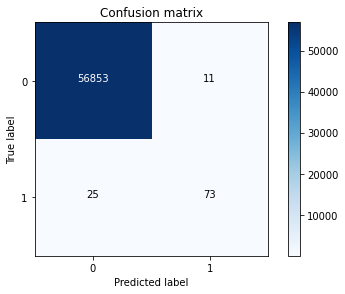

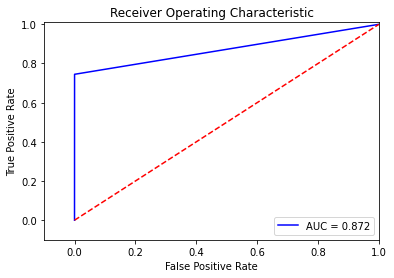

In [56]:
# 1. define model
lda = LinearDiscriminantAnalysis()

# 2. define model evaluation method
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 2612)

# 3. define grid for determining the best solver to use
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']

# 4. define search
search = GridSearchCV(lda, grid, scoring='roc_auc_ovr_weighted', cv=cv, n_jobs=-1)

# 5. perform the search
results = search.fit(X, y)

# 6. summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

# 7. Redefine model with the best solver
lda = LinearDiscriminantAnalysis(solver = 'svd')

# 8. evaluate model
scores = cross_val_score(lda, X_train_res, y_train_res, scoring = 'roc_auc_ovr_weighted', cv=cv, n_jobs = -1)

# 9. summarize result
print("Mean ROC_AUC score: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

# 10. Let's fit the model
lda.fit(X_train_norm, y_train)

# 11. Train Pred
print("Classificaiton Report: Train")
y_train_pred_lda = Prediction(lda, X_train_norm, y_train, "train dataset")

# 12. Test Pred
print("Classificaiton Report: Test")
y_test_pred_lda = Prediction(lda, X_test_norm, y_test, "test dataset")

# 13. ROC
ROCcurve(y_test_pred_lda, y_test)

### 2.5 QDA

Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    227451
           1       0.05      0.89      0.10       394

    accuracy                           0.97    227845
   macro avg       0.53      0.93      0.54    227845
weighted avg       1.00      0.97      0.98    227845



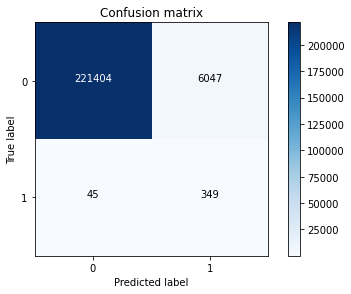

Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.87      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.92      0.54     56962
weighted avg       1.00      0.97      0.99     56962



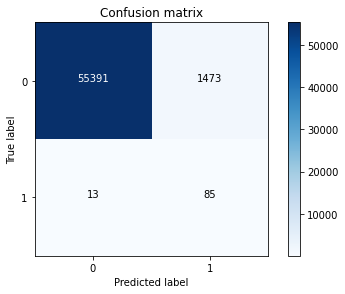

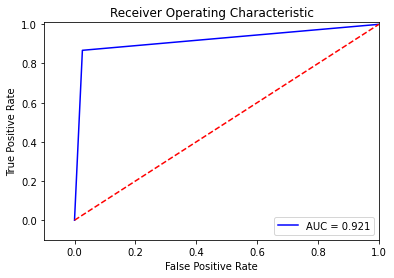

In [57]:
# 1. Define Model
qda = QuadraticDiscriminantAnalysis()

# 2. Fit model
qda.fit(X_train_res, y_train_res.ravel())

# 3. Train Pred
print("Classificaiton Report: Train")
y_train_pred_qda = Prediction(qda, X_train_norm, y_train, "train dataset")

# 4. Test Pred
print("Classificaiton Report: Test")
y_test_pred_qda = Prediction(qda, X_test_norm, y_test, "test dataset")

# 5. ROC
ROCcurve(y_test_pred_qda, y_test)

### 2.6 xgBoost

In [ ]:
# # Hyper Parameter Tuning
# space= {
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
#     'max_depth': hp.quniform('max_depth', 5, 15, 1),
#     'n_estimators': hp.quniform('n_estimators', 5, 35, 1),
#     'num_leaves': hp.quniform('num_leaves', 5, 50, 1),
#     'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
#     'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
#     'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
# }

# # Algorithm
# tpe_algorithm = tpe.suggest

# # Results
# trials = Trials()

# # evaluators
# num_eval = 100

# # Best Parameters
# best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=num_eval, trials=trials, rstate= np.random.RandomState(1))



Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



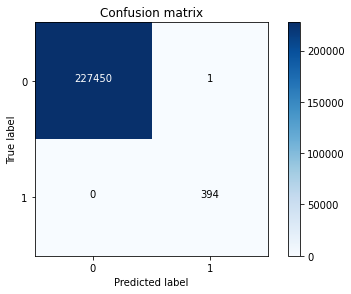

Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.58      0.83      0.68        98

    accuracy                           1.00     56962
   macro avg       0.79      0.91      0.84     56962
weighted avg       1.00      1.00      1.00     56962



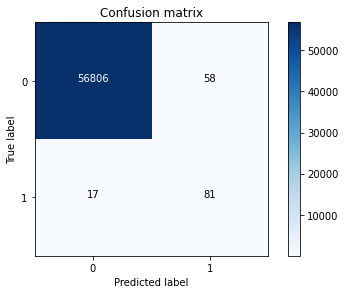

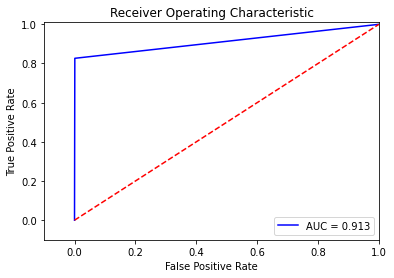

In [79]:
# 1. Define classifier
xgb_clf = xgb.XGBClassifier(scale_pos_weight=len(y_train_res[y_train_res==0])/len(y_train_res[y_train_res==1]),
                            random_state=1,
                            base_score=0.3)

# 2. Fit classifier
xgb_fit = xgb_clf.fit(X_train_res, y_train_res)

# 3. Train Pred
print("Classificaiton Report: Train")
y_train_pred_xgb = Prediction(xgb_fit, X_train_norm, y_train, "train dataset")

# 4. Test Pred
print("Classificaiton Report: Test")
y_test_pred_xgb = Prediction(xgb_fit, X_test_norm, y_test, "test dataset")

# 5. ROC
ROCcurve(y_test_pred_xgb, y_test)

### 2.7 catBoost

0:	total: 526ms	remaining: 4m 22s
50:	total: 18.8s	remaining: 2m 45s
100:	total: 36.8s	remaining: 2m 25s
150:	total: 55.1s	remaining: 2m 7s
200:	total: 1m 12s	remaining: 1m 48s
250:	total: 1m 30s	remaining: 1m 29s
300:	total: 1m 47s	remaining: 1m 11s
350:	total: 2m 4s	remaining: 52.8s
400:	total: 2m 21s	remaining: 35s
450:	total: 2m 41s	remaining: 17.5s
499:	total: 3m	remaining: 0us
Classificaiton Report: Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.91      1.00      0.95       394

    accuracy                           1.00    227845
   macro avg       0.95      1.00      0.98    227845
weighted avg       1.00      1.00      1.00    227845



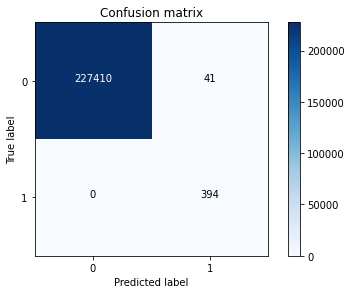

Classificaiton Report: Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.62      0.84      0.71        98

    accuracy                           1.00     56962
   macro avg       0.81      0.92      0.85     56962
weighted avg       1.00      1.00      1.00     56962



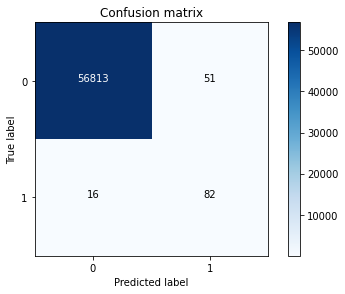

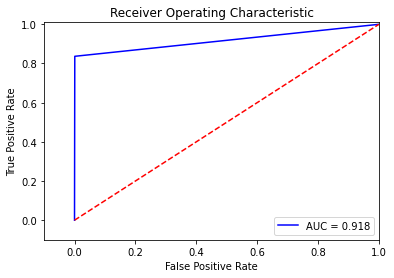

In [82]:
# 1. Define Model
cb_clf = cb.CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 2612,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100)

# 2. Fit the model
cb_fit = cb_clf.fit(X_train_res, y_train_res)

# 3. Train Pred
print("Classificaiton Report: Train")
y_train_pred_cb = Prediction(cb_fit, X_train_norm, y_train, "train dataset")

# 4. Test Pred
print("Classificaiton Report: Test")
y_test_pred_cb = Prediction(cb_fit, X_test_norm, y_test, "test dataset")

# 5. ROC
ROCcurve(y_test_pred_cb, y_test)

### 2.8 Neural Net

#### 2.8.1 Extreme Learning Machines

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    227451
           1       0.14      0.99      0.25       394

    accuracy                           0.99    227845
   macro avg       0.57      0.99      0.62    227845
weighted avg       1.00      0.99      0.99    227845



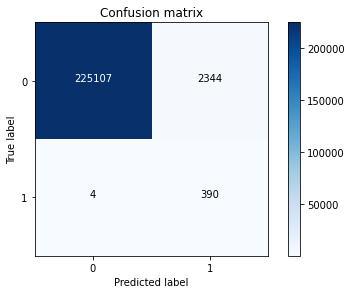

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.84      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.91      0.60     56962
weighted avg       1.00      0.99      0.99     56962



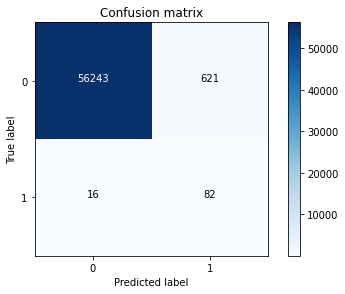

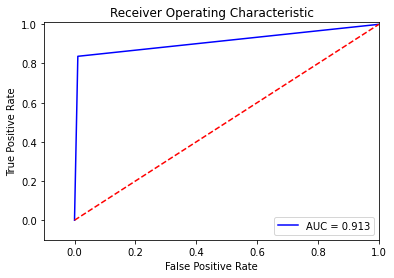

In [131]:
# 1. Size of the input layer
input_size = X_train_res.shape[1]

# 2. Number of hidden nodes. We will have only one hidden layer
hidden_size = 1000

# 3. Initialize input weights and biases randomly, drawn from a Gaussian distribution
input_weights = np.random.normal(size = [input_size, hidden_size])
biases = np.random.normal(size = [hidden_size])

# 4. Activation function - ReLU
def relu(x):
    return np.maximum(x,0,x)

# 5. Hidden Nodes
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

# 6. Output weights
output_weights = np.dot(pinv2(hidden_nodes(X_train_res)), y_train_res)

# 7. Predict
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

# 8. Classification Matrix
def elm_cf(y, y_hat):
    cnf_matrix = confusion_matrix(y, y_hat) 

    print(classification_report(y, y_hat, labels=[0, 1]))

    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
    plt.show()

# 9. train Prediction
train_pred = predict(X_train_norm)
elm_train_pred = (train_pred > 0.5).astype(int)
elm_cf(y_train, elm_train_pred)

# 10. test Prediction
test_pred = predict(X_test_norm)
elm_test_pred = (test_pred > 0.5).astype(int)
elm_cf(y_test, elm_test_pred)

# 11. ROC
ROCcurve(elm_test_pred, y_test)